In [678]:
# extract the spectrum given the airy disk, compare to analytic expression for fisher information
# Gonna look at for a random signal
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [698]:
diameter = 0.125
period = 304e-6
# modifications to the pscale (and hence wavelength range)
wl_unc = 1

N = 1024              # number of samples
dx = 5*0.004 * 10*10**(-9) # wavelength spacing, for ~ 1000 samples in 10 nm
# can just decrease the wavelength spacing...
fs = 1 / dx           # sampling frequency
freqs = np.fft.fftfreq(N, d=dx)

min_wavelength =565e-9

# Desired frequency band (in Hz)
f_low = 0

max_wavelength = min_wavelength + dx*N

wl_bound = (max_wavelength - min_wavelength)*wl_unc

# should really get a pixel scale dependence thing here but i'm just gonna multiply be pscale min and max for now
max_spec_freq = (np.sqrt(2)/period) * (diameter/(min_wavelength-wl_bound))

low_max_spec_freq = (np.sqrt(2)/period) * (diameter/(max_wavelength+wl_bound))

f_high = 4*max_spec_freq

In [699]:
key = jr.PRNGKey(25)

# Create a complex array of zeros
spectrum = np.zeros(N, dtype=np.complex64)

# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(N,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(N,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:N//2].set(spec[1:N//2])
    spec = spec.at[-(N//2)+1:].set(np.conj(spec[1:N//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)


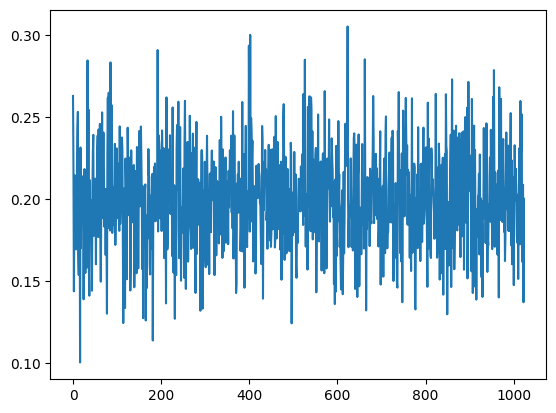

In [700]:
signal = np.fft.ifft(spectrum).real
# spectrum_filtered = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
# spectrum_filtered_low = spectrum.at[np.abs(freqs) > low_max_spec_freq].set(0)
# signal_filtered = np.fft.ifft(spectrum_filtered).real
# signal_filtered_low = np.fft.ifft(spectrum_filtered_low).real

if np.min(signal) <= 0:
    # signal_filtered += -2*np.min(signal)
    # signal_filtered_low += -2*np.min(signal)
    signal += -2*np.min(signal)

plt.plot(signal)
plt.show()

In [866]:
wavelengths = np.linspace(min_wavelength, max_wavelength, N)
# wavelengths = np.array([585e-9])

nyquist_sample_interval = 1/(2*max_spec_freq)

sample_interval = 0.4*nyquist_sample_interval #quarter nyquist

n_wavelengths_sample = int(np.ceil((max_wavelength-min_wavelength+2*wl_bound)/sample_interval))

wavelengths_sample = np.linspace(min_wavelength - wl_bound, max_wavelength + wl_bound, n_wavelengths_sample)

weights_initial = np.ones(n_wavelengths_sample) # log weights, but init at 1

flux = 40*(2.909*10**7)*(4/11)

source = dl.PointSource(wavelengths, flux=flux, weights=signal)

source_model = dl.PointSource(wavelengths_sample, flux=flux, weights=weights_initial)

wf_npixels = 2*1024#128 # 128 lowest power of 2 necessary

# circular aperture
# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npixels, diameter)
aperture = dlu.circle(coords, 0.5 * diameter)
# normalise = true
apertureLayer = dl.TransmissiveLayer(aperture, True)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 32

psf_pixel_scale = 0.375
oversample = 2 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

telescope = dl.Telescope(optics, source)

telescope_model = dl.Telescope(optics, source_model)

psf = telescope.model()
psf_poisson = jr.poisson(jr.PRNGKey(0), psf)

In [702]:
weights_path = 'source.spectrum.weights'

parameters = [weights_path]

model = telescope_model

# Optimisation
# 10% initial learning rate.
weights_optimiser = optax.adam(0.5)

optimisers = [weights_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [703]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    # LOG WEIGHTS OPTIMISATION: THIS MAKES IT SOOOO MUCH BETTER!!!
    log_weights = model.get(weights_path)
    weights = np.exp(log_weights)
    model = model.set(weights_path, weights)
    out = model.model()
    # poisson log loss (very good stuff)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [704]:
losses, models_out = [], []
n_iter = 150
with tqdm(range(n_iter),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, psf_poisson)

        updates, opt_state = optim.update(grads, opt_state)

        # just do log weight optimisation
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Log Loss: 4.383: 100%|██████████| 150/150 [03:55<00:00,  1.57s/it]


In [720]:
model_log_weights = models_out[-1].weights
model_weights = np.exp(model_log_weights)
final_model = models_out[-1].set(weights_path, model_weights)
model_psf = final_model.model()

# extra wavelengths
N_extra = int(np.ceil(wl_bound/dx))
wl_extra_bound = N_extra*dx
wavelengths_extra = np.linspace(min_wavelength - wl_extra_bound, max_wavelength + wl_extra_bound, N + 2*N_extra)


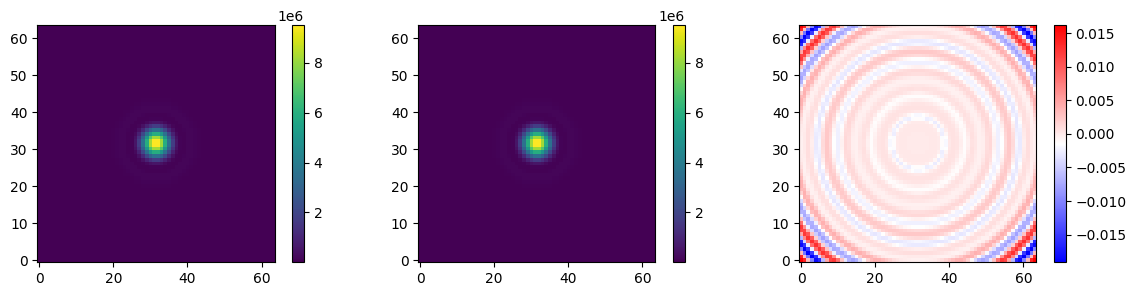

In [721]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(model_psf, origin='lower')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(psf, origin='lower')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow((model_psf-psf)/psf,origin='lower', cmap='bwr')
plt.colorbar()
plt.tight_layout()
plt.show()

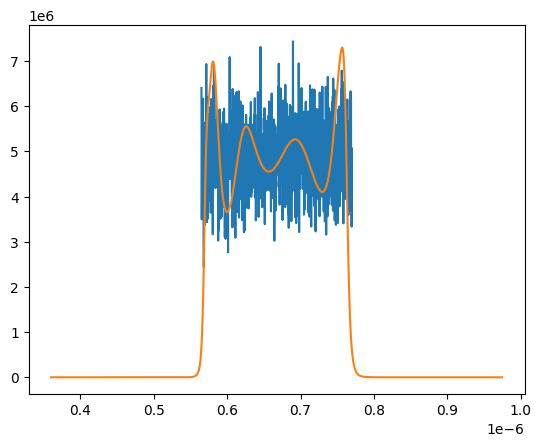

In [ ]:
# signal norm, model norm
d_wl_signal = wavelengths[1]- wavelengths[0]
signal_norm = signal/(np.sum(signal)*d_wl_signal)
d_wl_model = wavelengths_sample[1] - wavelengths_sample[0]
model_norm = model_weights/(np.sum(model_weights)*d_wl_model)
plt.
plt.plot(wavelengths, signal_norm)
plt.plot(wavelengths_sample, model_norm)
plt.show()

In [723]:
np.sum(signal_norm*d_wl_signal)

Array(1., dtype=float32)

In [859]:
# defining the mellin transform:, updated to use dimensionless arguments ?

def mellin_wavelengths(wavelengths, weights, freqs, lambda0):
    lam = wavelengths/lambda0

    d_lam = (wavelengths[1]-wavelengths[0])/lambda0

    prefac = 1/np.sqrt(2*np.pi)

    mellin = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel = np.sum(weights * lam**(1j * freq - 1) * d_lam)
        mellin = mellin.at[idx].set(mel)

    mellin *= prefac
    return mellin

In [902]:
max_freq = 50
freqs = np.linspace(-max_freq, max_freq, 256)

signal_mel = mellin_wavelengths(wavelengths, signal_norm, freqs, 1)# 585e-9)
model_mel = mellin_wavelengths(wavelengths_sample, model_norm, freqs, 1)#585e-9)

In [903]:
from scipy.special import loggamma


def h_kernel(freqs, diameter):
    logfisher = loggamma(1-1j*freqs/2) + loggamma(1/2 + 1j*freqs/2) - loggamma(1/2) - loggamma(3/2 - 1j*freqs/2) - loggamma(5/2 - 1j*freqs/2)

    prefac = (np.pi**(-1j*freqs) * diameter**(1-1j*freqs))/(2*np.sqrt(2*np.pi))

    fisher = np.exp(logfisher)

    fisher *= prefac
    return fisher

h_kern = h_kernel(freqs, diameter)

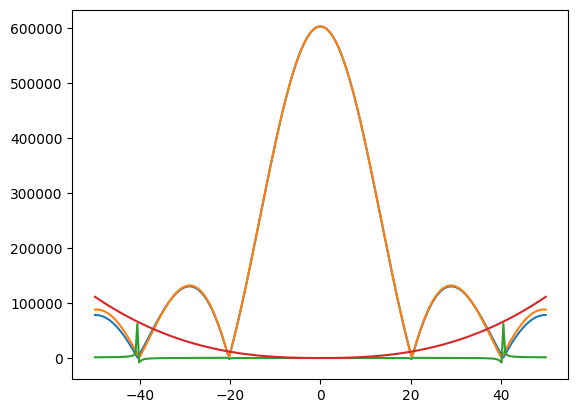

In [904]:
plt.plot(freqs, np.abs(signal_mel))
plt.plot(freqs, np.abs(model_mel))

plt.plot(freqs, 10000*(np.abs(model_mel)-np.abs(signal_mel))/np.abs(signal_mel))

plt.plot(freqs, 0.5/np.abs(h_kern))
#plt.xlim(-200,200)
plt.show()

In [905]:
r_coords = dlu.pixel_coords(psf_npixels*oversample, dlu.arcsec2rad(psf_pixel_scale*psf_npixels),True)[0]

# factor I used before: *oversample*1.2745

In [961]:
from jax import vmap

def polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs, r0):
    p = np.log(r_coords/r0)

    prefac = 1/(r_coords)# NO FACTOR OF sqrt2pi,,, cancels because unitary fourier transform convolution theorem * np.sqrt(2*np.pi))
    d_freq = freqs[1] - freqs[0]

    def single_poly(pv):
        return np.sum(mellin_spec * h_hat * np.exp(-1.0j * freqs * pv) * d_freq)

    flat = vmap(single_poly)(p.ravel())
    polychrome = flat.reshape(r_coords.shape) * prefac
    return polychrome

In [962]:
# requires linear wavelenght distribution
from jax.scipy.special import j1

def polyairydisk(r_coords, wavelengths, norm_weights, diameter):
    d_wl = wavelengths[1] - wavelengths[0]
    def single_wavelength(r):
        return np.sum(norm_weights * (1/wavelengths**2) * np.pi * diameter**2 * (j1(np.pi*diameter*r/wavelengths))**2/(np.pi*diameter*r/wavelengths)**2 * d_wl)
    
    flat = vmap(single_wavelength)(r_coords.ravel())
    polyairy = flat.reshape(r_coords.shape)

    return polyairy


In [963]:
psf_analytic = polyairydisk(r_coords, wavelengths, signal_norm, diameter)

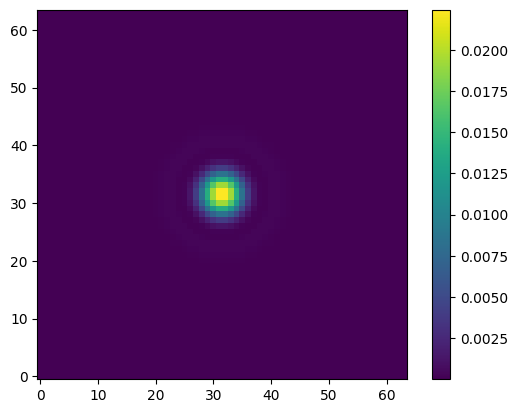

In [964]:
plt.imshow(psf_analytic*dlu.arcsec2rad(psf_pixel_scale/oversample)**2, origin='lower')
plt.colorbar()
plt.show()

In [965]:
max_freq = 2000
freqs = np.linspace(-max_freq, max_freq, 2**7*2048)

signal_mel = mellin_wavelengths(wavelengths, signal_norm, freqs, 1)# 585e-9)

In [966]:
r_naught = 1#(np.pi*diameter)
h_kern = h_kernel(freqs, diameter)
polyimage = polychrome_image_jax(r_coords, signal_mel, h_kern, freqs, r_naught)

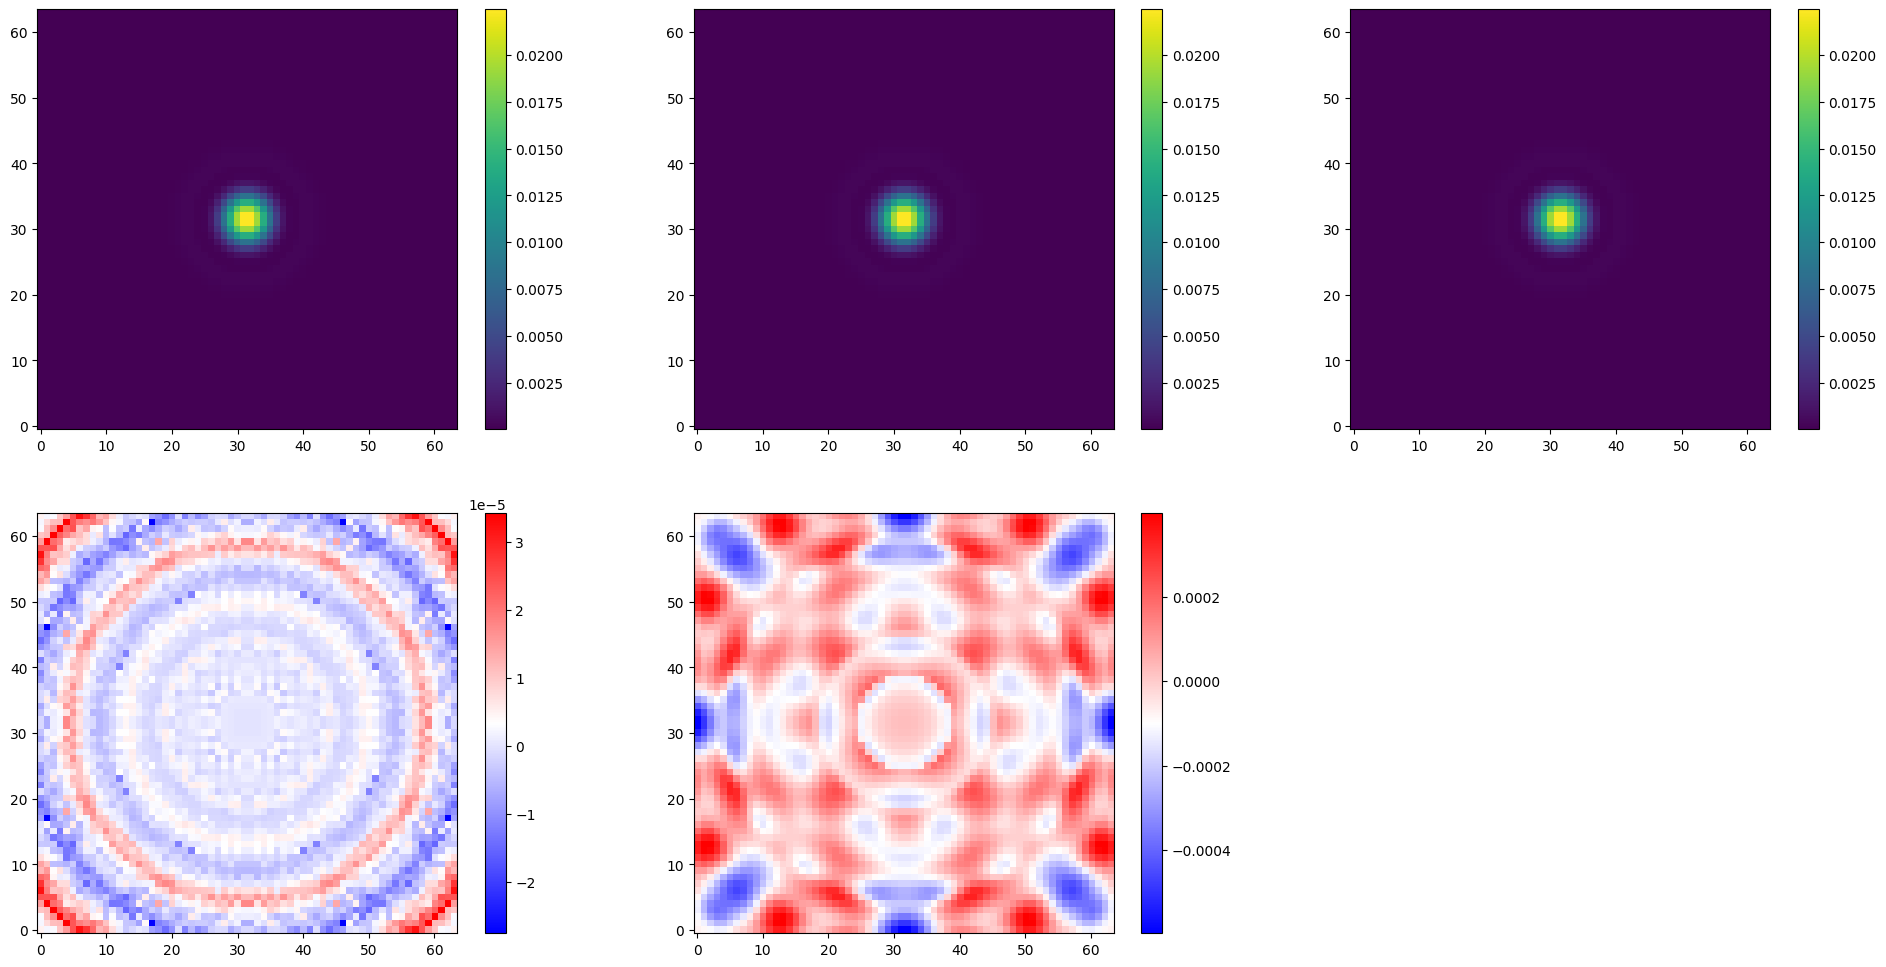

In [ ]:
plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.imshow((np.real(polyimage)*dlu.arcsec2rad(psf_pixel_scale/oversample)**2),origin='lower')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow((psf/flux),origin='lower')
plt.colorbar()


plt.subplot(2,3,3)
plt.imshow(psf_analytic*dlu.arcsec2rad(psf_pixel_scale/oversample)**2, origin='lower')
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow((np.real(polyimage)/np.max(np.real(polyimage))) /(psf_analytic/np.max(psf_analytic)) -1, origin = 'lower', cmap = 'bwr')
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow((psf/flux)/(psf_analytic*dlu.arcsec2rad(psf_pixel_scale/oversample)**2) - 1 ,origin='lower', cmap='bwr')
plt.colorbar()

plt.show()
# MAN THIS IS CLOSE.. fluxes are stillfckd thouh
# very strange,, requires rescaling of r coordinates.
# not quite sure what's going on
# if I had to guess: probably something to do with the h-kernel?


# flux is still whack, but excluding the weird flux factor it's pretty good

# FLUX FACTOR CAME FROM ERROR IN CONVOLUTION THEOREM, CORRECTING IT GIVES CORRECT RESULT!!

In [956]:
# try making an inverse mellin for the spectrum
np.max(np.real(polyimage)*dlu.arcsec2rad(psf_pixel_scale/oversample)**2*2.50000001095)/(np.max(psf)/flux)

Array(0.9973306, dtype=float32)

In [970]:
1/np.median(np.real(polyimage)/psf_analytic)

Array(0.9999995, dtype=float32)

In [796]:
np.sum(np.real(polyimage)*dlu.arcsec2rad(psf_pixel_scale/oversample)**2)

Array(0.38562003, dtype=float32)

In [793]:
np.sum(psf/flux)

Array(0.9666053, dtype=float32)

In [792]:
0.125**1*np.pi**2

1.2337005501361697

In [807]:
np.max(psf)/flux*(1/dlu.arcsec2rad(psf_pixel_scale/oversample)**2)

Array(2.720495e+10, dtype=float32)

In [739]:
# perhaps something to do wtih normalisation.. as in .. we need it in terms of photons per pixel
dlu.arcsec2rad(psf_pixel_scale/oversample)**2


# I think its to do with the convolution. I need to scale my spectrum such that my log spectrum (spectrum in log space) has unit flux
# ?? maybe... need to think about it more.
# also, fisher calcs need to be done... running out of time

8.263276361401599e-13

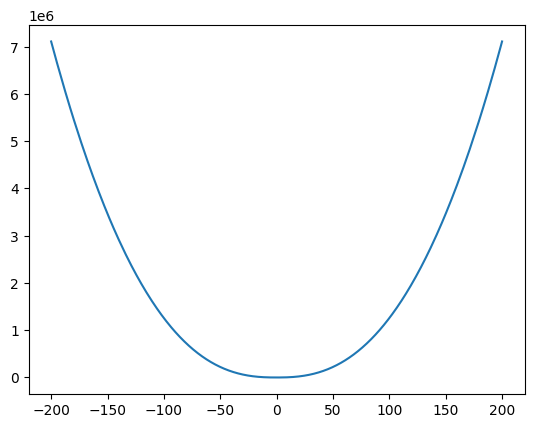

In [753]:
plt.plot(freqs, 1/np.abs(1*h_kern))
plt.show()

In [804]:
np.pi*diameter**2/4

0.01227184630308513

In [810]:
print(np.max(np.real(polyimage))*dlu.arcsec2rad(psf_pixel_scale/oversample)**2)

0.008952828
